# Определение перспективного тарифа для телеком-компании

Коммерческий департамент федерального оператора сотовой связи заказал провести анализ поведения клиентов, чтобы скорректировать рекламный бюджет. Переданы данные за 2018 год о 500 клиентах компании. Нужно определить, какой из двух предложенных тарифов будет лучше.

# Цель 
- Оценить расходемые объемы всех параметров для двух тарифов 
- Определить тариф, который приносит больше денег компании

Описание тарифов
##### Тариф «Смарт»
1.	Ежемесячная плата: 550 рублей
2.	Включено 500 минут разговора, 50 сообщений и 15 Гб интернет-трафика
3.	Стоимость услуг сверх тарифного пакета: 1. минута разговора: 3 рубля («Мегалайн» всегда округляет вверх значения минут и мегабайтов. Если пользователь проговорил всего 1 секунду, в тарифе засчитывается целая минута); 2. сообщение: 3 рубля; 3. 1 Гб интернет-трафика: 200 рублей.
###### Тариф «Ультра»
1.	Ежемесячная плата: 1950 рублей
2.	Включено 3000 минут разговора, 1000 сообщений и 30 Гб интернет-трафика
3.	Стоимость услуг сверх тарифного пакета: 1. минута разговора: 1 рубль; 2. сообщение: 1 рубль; 3. 1 Гб интернет-трафика: 150 рублей.
###### Примечание:
«Мегалайн» всегда округляет секунды до минут, а мегабайты — до гигабайт. Каждый звонок округляется отдельно: даже если он длился всего 1 секунду, будет засчитан как 1 минута.
Для веб-трафика отдельные сессии не считаются. Вместо этого общая сумма за месяц округляется в бо́льшую сторону. Если абонент использует 1025 мегабайт в этом месяце, с него возьмут плату за 2 гигабайта.

# Описание данных 
Таблица users (информация о пользователях):
- user_id — уникальный идентификатор пользователя
- first_name — имя пользователя
- last_name — фамилия пользователя
- age — возраст пользователя (годы)
- reg_date — дата подключения тарифа (день, месяц, год)
- churn_date — дата прекращения пользования тарифом (если значение пропущено, то тариф ещё действовал на момент выгрузки данных)
- city — город проживания пользователя
- tariff — название тарифного плана

Таблица calls (информация о звонках):
- id — уникальный номер звонка
- call_date — дата звонка
- duration — длительность звонка в минутах
- user_id — идентификатор пользователя, сделавшего звонок

Таблица messages (информация о сообщениях):
- id — уникальный номер сообщения
- message_date — дата сообщения
- user_id — идентификатор пользователя, отправившего сообщение

Таблица internet (информация об интернет-сессиях):
- id — уникальный номер сессии
- mb_used — объём потраченного за сессию интернет-трафика (в мегабайтах)
- session_date — дата интернет-сессии
- user_id — идентификатор пользователя

Таблица tariffs (информация о тарифах):
- tariff_name — название тарифа
- rub_monthly_fee — ежемесячная абонентская плата в рублях
- minutes_included — количество минут разговора в месяц, включённых в абонентскую плату
- messages_included — количество сообщений в месяц, включённых в абонентскую плату
- mb_per_month_included — объём интернет-трафика, включённого в абонентскую плату (в мегабайтах)
- rub_per_minute — стоимость минуты разговора сверх тарифного пакета (например, если в тарифе 100 минут разговора в месяц, то со 101 минуты будет взиматься плата)
- rub_per_message — стоимость отправки сообщения сверх тарифного пакета
- rub_per_gb — стоимость дополнительного гигабайта интернет-трафика сверх тарифного пакета (1 гигабайт = 1024 мегабайта)

## 1. Изучение данных из файла

In [1]:
import pandas as pd
import numpy as np
from scipy import stats as st

try:
    calls = pd.read_csv('E:/Python/Project 3/calls.csv')
except:
    calls = pd.read_csv('/datasets/calls.csv')

calls.info()
calls

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 202607 entries, 0 to 202606
Data columns (total 4 columns):
id           202607 non-null object
call_date    202607 non-null object
duration     202607 non-null float64
user_id      202607 non-null int64
dtypes: float64(1), int64(1), object(2)
memory usage: 6.2+ MB


,id,call_date,duration,user_id
0,1000_0,2018-07-25,0.00,1000
1,1000_1,2018-08-17,0.00,1000
2,1000_2,2018-06-11,2.85,1000
3,1000_3,2018-09-21,13.80,1000
4,1000_4,2018-12-15,5.18,1000
...,...,...,...,...
202602,1499_215,2018-12-26,0.76,1499
202603,1499_216,2018-10-18,18.83,1499
202604,1499_217,2018-11-10,10.81,1499
202605,1499_218,2018-10-06,4.27,1499


In [2]:
try:
    internet = pd.read_csv('E:/Python/Project 3/internet.csv')
except:
    internet = pd.read_csv('/datasets/internet.csv')

internet.info()
internet

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 149396 entries, 0 to 149395
Data columns (total 5 columns):
Unnamed: 0      149396 non-null int64
id              149396 non-null object
mb_used         149396 non-null float64
session_date    149396 non-null object
user_id         149396 non-null int64
dtypes: float64(1), int64(2), object(2)
memory usage: 5.7+ MB


,Unnamed: 0,id,mb_used,session_date,user_id
0,0,1000_0,112.95,2018-11-25,1000
1,1,1000_1,1052.81,2018-09-07,1000
2,2,1000_2,1197.26,2018-06-25,1000
3,3,1000_3,550.27,2018-08-22,1000
4,4,1000_4,302.56,2018-09-24,1000
...,...,...,...,...,...
149391,149391,1499_152,318.90,2018-10-03,1499
149392,149392,1499_153,490.13,2018-12-14,1499
149393,149393,1499_154,0.00,2018-10-27,1499
149394,149394,1499_155,1246.32,2018-11-26,1499


In [3]:
try:
    messages = pd.read_csv('E:/Python/Project 3/messages.csv')
except:
    messages = pd.read_csv('/datasets/messages.csv')
messages.info()
messages

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 123036 entries, 0 to 123035
Data columns (total 3 columns):
id              123036 non-null object
message_date    123036 non-null object
user_id         123036 non-null int64
dtypes: int64(1), object(2)
memory usage: 2.8+ MB


,id,message_date,user_id
0,1000_0,2018-06-27,1000
1,1000_1,2018-10-08,1000
2,1000_2,2018-08-04,1000
3,1000_3,2018-06-16,1000
4,1000_4,2018-12-05,1000
...,...,...,...
123031,1499_179,2018-12-12,1499
123032,1499_180,2018-09-28,1499
123033,1499_181,2018-09-27,1499
123034,1499_182,2018-11-15,1499


In [4]:
try:
    tariffs = pd.read_csv('E:/Python/Project 3/tariffs.csv')
except:
    tariffs = pd.read_csv('/datasets/tariffs.csv')
tariffs.info()
tariffs

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2 entries, 0 to 1
Data columns (total 8 columns):
messages_included        2 non-null int64
mb_per_month_included    2 non-null int64
minutes_included         2 non-null int64
rub_monthly_fee          2 non-null int64
rub_per_gb               2 non-null int64
rub_per_message          2 non-null int64
rub_per_minute           2 non-null int64
tariff_name              2 non-null object
dtypes: int64(7), object(1)
memory usage: 256.0+ bytes


,messages_included,mb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute,tariff_name
0,50,15360,500,550,200,3,3,smart
1,1000,30720,3000,1950,150,1,1,ultra


In [5]:
try:
    users = pd.read_csv('E:/Python/Project 3/users.csv')
except:
    users = pd.read_csv('/datasets/users.csv')
users.info()
users

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 8 columns):
user_id       500 non-null int64
age           500 non-null int64
churn_date    38 non-null object
city          500 non-null object
first_name    500 non-null object
last_name     500 non-null object
reg_date      500 non-null object
tariff        500 non-null object
dtypes: int64(2), object(6)
memory usage: 31.4+ KB


,user_id,age,churn_date,city,first_name,last_name,reg_date,tariff
0,1000,52,NaN,Краснодар,Рафаил,Верещагин,2018-05-25,ultra
1,1001,41,NaN,Москва,Иван,Ежов,2018-11-01,smart
2,1002,59,NaN,Стерлитамак,Евгений,Абрамович,2018-06-17,smart
3,1003,23,NaN,Москва,Белла,Белякова,2018-08-17,ultra
4,1004,68,NaN,Новокузнецк,Татьяна,Авдеенко,2018-05-14,ultra
...,...,...,...,...,...,...,...,...
495,1495,65,NaN,Иркутск,Авксентий,Фокин,2018-08-28,ultra
496,1496,36,NaN,Вологда,Трифон,Блохин,2018-01-27,smart
497,1497,32,NaN,Челябинск,Каролина,Агеева,2018-10-09,smart
498,1498,68,2018-10-25,Владикавказ,Всеволод,Акимчин,2018-07-19,smart


### Вывод

В предоставленных данных видим 5 различных таблиц, 2 из которых носят информационный характер и 3, в которых зафиксировано каждое действие пользователя. Всего предоставлены данные о 500 пользователях. 

На первый взгляд в данных нет пропусков, которые нам бы помешали работать, однако нужно проверить данные на наличие дубликатов и привести данные к нужным типам.

## 2. Предобработка данных
### 2.1 Обработка дубликатов

In [6]:
calls.duplicated().sum()

0

In [7]:
internet.duplicated().sum()

0

In [8]:
messages.duplicated().sum()

0

In [9]:
users.duplicated().sum()

0

Дубликатов не обнаружено.

Проверим, как записаны названия всех городов:

In [10]:
users['city'].value_counts()

Москва             99
Санкт-Петербург    39
Новосибирск        16
Омск               14
Казань             14
                   ..
Иваново             1
Химки               1
Нижневартовск       1
Подольск            1
Архангельск         1
Name: city, Length: 76, dtype: int64

In [11]:
#users['city']=users['city'].str.lower()
#users['city'].value_counts()

Названия одинаковых городов были записаны одинаковым регистром, поэтому вернем все в исходный вид.

### 2.1 Приведение данных к нужным типам
Т.К. по условиям компании округление минут идет в большую сторону, учтем это условие при переводе: 

In [12]:
calls['duration_min'] = calls['duration'] + 0.99
calls['duration_min'] = calls['duration_min'].astype('int')

Для веб-трафика условие более сложное, поэтому осуществим перевод после подсчета помесечного трафика.

### Вывод
Видно, что данные предоставлены довольно качественные.  Даты пока не трогаем, т.к. они и так записаны в правильном формате.

## 3. Составление сводной таблицы с данными по каждому пользователю
-	количество сделанных звонков и израсходованных минут разговора по месяцам;
-	количество отправленных сообщений по месяцам;
-	объем израсходованного интернет-трафика по месяцам;
-	помесячную выручку с каждого пользователя (вычтите бесплатный лимит из суммарного количества звонков, сообщений и интернет-трафика; остаток умножьте на значение из тарифного плана; прибавьте абонентскую плату, соответствующую тарифному плану).


In [13]:
# Выделим столбцы с месяцем и годом
calls['year']= pd.DatetimeIndex(calls['call_date']).year
calls['month']= pd.DatetimeIndex(calls['call_date']).month
calls['year'].value_counts() # Узнали, что год только 2018, поэтому учитываем только месяца

calls_month=calls.pivot_table(
    index='user_id', 
    columns = 'month', 
    values = 'id', 
    aggfunc = 'count'
)
calls_month

month,1,2,3,4,5,6,7,8,9,10,11,12
user_id,,,,,,,,,,,,
1000,NaN,NaN,NaN,NaN,22.0,43.0,47.0,52.0,58.0,57.0,43.0,46.0
1001,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,59.0,63.0
1002,NaN,NaN,NaN,NaN,NaN,15.0,26.0,42.0,36.0,33.0,32.0,33.0
1003,NaN,NaN,NaN,NaN,NaN,NaN,NaN,55.0,134.0,108.0,115.0,108.0
1004,NaN,NaN,NaN,NaN,9.0,31.0,22.0,19.0,26.0,29.0,19.0,21.0
...,...,...,...,...,...,...,...,...,...,...,...,...
1495,NaN,NaN,NaN,NaN,NaN,NaN,NaN,17.0,112.0,152.0,129.0,155.0
1496,7.0,77.0,79.0,67.0,63.0,74.0,73.0,88.0,68.0,72.0,80.0,80.0
1497,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,66.0,64.0,71.0


In [14]:
calls_month_min=calls.pivot_table(
    index='user_id', 
    columns = 'month', 
    values = 'duration_min', 
    aggfunc = 'sum'
)
calls_month_min

month,1,2,3,4,5,6,7,8,9,10,11,12
user_id,,,,,,,,,,,,
1000,NaN,NaN,NaN,NaN,159.0,172.0,340.0,408.0,466.0,350.0,338.0,333.0
1001,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,430.0,414.0
1002,NaN,NaN,NaN,NaN,NaN,117.0,214.0,289.0,206.0,212.0,243.0,236.0
1003,NaN,NaN,NaN,NaN,NaN,NaN,NaN,380.0,961.0,855.0,824.0,802.0
1004,NaN,NaN,NaN,NaN,35.0,171.0,135.0,137.0,117.0,145.0,117.0,130.0
...,...,...,...,...,...,...,...,...,...,...,...,...
1495,NaN,NaN,NaN,NaN,NaN,NaN,NaN,92.0,813.0,1030.0,954.0,1031.0
1496,48.0,594.0,557.0,521.0,484.0,555.0,582.0,527.0,486.0,450.0,662.0,518.0
1497,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,490.0,371.0,545.0


Для сообщений и интернета:

In [15]:
messages['month']= pd.DatetimeIndex(messages['message_date']).month
messages_month=messages.pivot_table(
    index='user_id', 
    columns = 'month', 
    values = 'id', 
    aggfunc = 'count'
)
messages_month

month,1,2,3,4,5,6,7,8,9,10,11,12
user_id,,,,,,,,,,,,
1000,NaN,NaN,NaN,NaN,22.0,60.0,75.0,81.0,57.0,73.0,58.0,70.0
1002,NaN,NaN,NaN,NaN,NaN,4.0,11.0,13.0,4.0,10.0,16.0,12.0
1003,NaN,NaN,NaN,NaN,NaN,NaN,NaN,37.0,91.0,83.0,94.0,75.0
1004,NaN,NaN,NaN,NaN,95.0,134.0,181.0,151.0,146.0,165.0,158.0,162.0
1005,7.0,38.0,56.0,41.0,42.0,47.0,56.0,64.0,52.0,44.0,51.0,54.0
...,...,...,...,...,...,...,...,...,...,...,...,...
1495,NaN,NaN,NaN,NaN,NaN,NaN,NaN,13.0,82.0,82.0,79.0,84.0
1496,9.0,45.0,46.0,49.0,40.0,35.0,42.0,41.0,29.0,35.0,46.0,51.0
1497,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,20.0,14.0,17.0


In [16]:
internet['month']= pd.DatetimeIndex(internet['session_date']).month
internet_month=internet.pivot_table(
    index='user_id', 
    columns = 'month', 
    values = 'mb_used', 
    aggfunc = 'sum'
)

# По правилам оператора, мегобайты за месяц округляются до гигабайт в большую сторону:

for column in internet_month:
    internet_month[column] = np.ceil(internet_month[column]/1024)
internet_month

month,1,2,3,4,5,6,7,8,9,10,11,12
user_id,,,,,,,,,,,,
1000,NaN,NaN,NaN,NaN,3.0,23.0,14.0,14.0,15.0,15.0,15.0,10.0
1001,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,18.0,14.0
1002,NaN,NaN,NaN,NaN,NaN,11.0,18.0,20.0,17.0,14.0,19.0,18.0
1003,NaN,NaN,NaN,NaN,NaN,NaN,NaN,9.0,13.0,15.0,12.0,10.0
1004,NaN,NaN,NaN,NaN,14.0,18.0,22.0,28.0,15.0,19.0,16.0,18.0
...,...,...,...,...,...,...,...,...,...,...,...,...
1495,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.0,33.0,29.0,39.0,23.0
1496,4.0,28.0,25.0,21.0,24.0,20.0,24.0,23.0,27.0,28.0,25.0,21.0
1497,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,12.0,14.0,20.0


Помесячная выручка с каждого пользователя:

In [17]:
# Сгруппируем каждую таблицу звонков по нужным параметрам:
calls_group = calls.groupby(['user_id', 'month']).agg({'duration_min':'sum'}).reset_index()
calls_group


,user_id,month,duration_min
0,1000,5,159
1,1000,6,172
2,1000,7,340
3,1000,8,408
4,1000,9,466
...,...,...,...
3169,1498,10,247
3170,1499,9,70
3171,1499,10,449
3172,1499,11,612


In [18]:
# Сгруппируем остальные таблицы:
messages_group = messages.groupby(['user_id', 'month']).agg({'id':'count'}).reset_index()
messages_group.columns = ['user_id', 'month', 'messages']
messages_group

,user_id,month,messages
0,1000,5,22
1,1000,6,60
2,1000,7,75
3,1000,8,81
4,1000,9,57
...,...,...,...
2712,1498,10,42
2713,1499,9,11
2714,1499,10,48
2715,1499,11,59


In [19]:
internet_group = internet.groupby(['user_id', 'month']).agg({'mb_used':'sum'}).reset_index()

# По правилам оператора, мегобайты за месяц округляются до гигабайт в большую сторону:
for element in internet_group['mb_used']:
    internet_group['gb_used'] = np.ceil(internet_group['mb_used']/1024)

internet_group.pop('mb_used')
internet_group

,user_id,month,gb_used
0,1000,5,3.0
1,1000,6,23.0
2,1000,7,14.0
3,1000,8,14.0
4,1000,9,15.0
...,...,...,...
3198,1498,10,21.0
3199,1499,9,2.0
3200,1499,10,18.0
3201,1499,11,18.0


In [20]:
all_group = calls_group.merge(messages_group, how ='outer', on = ['user_id', 'month'])
all_group = all_group.merge(internet_group, how ='outer', on = ['user_id', 'month'])
all_group = all_group.merge(users[['user_id', 'tariff']], how = 'right', on = 'user_id')
all_group

,user_id,month,duration_min,messages,gb_used,tariff
0,1000,5.0,159.0,22.0,3.0,ultra
1,1000,6.0,172.0,60.0,23.0,ultra
2,1000,7.0,340.0,75.0,14.0,ultra
3,1000,8.0,408.0,81.0,14.0,ultra
4,1000,9.0,466.0,57.0,15.0,ultra
...,...,...,...,...,...,...
3211,1489,10.0,NaN,21.0,20.0,smart
3212,1489,11.0,NaN,20.0,18.0,smart
3213,1489,12.0,NaN,35.0,17.0,smart
3214,1128,NaN,NaN,NaN,NaN,ultra


In [21]:
def month_cash(data):
    if data['tariff'] == 'smart':
        ind = 0
    else:
        ind = 1
    summ = tariffs.loc[ind, 'rub_monthly_fee']
    minut = data['duration_min'] - tariffs.loc[ind, 'minutes_included']
    mass = data['messages'] - tariffs.loc[ind, 'messages_included']
    gb = data['gb_used'] - (tariffs.loc[ind, 'mb_per_month_included'] / 1024)
    if minut > 0:
        summ += minut * tariffs.loc[ind, 'rub_per_minute']
    if mass > 0:
        summ += mass * tariffs.loc[ind, 'rub_per_message']
    if gb > 0:
        summ += gb * tariffs.loc[ind, 'rub_per_gb'] 
    return summ
all_group['cash'] = all_group.apply(month_cash, axis=1)
all_group

,user_id,month,duration_min,messages,gb_used,tariff,cash
0,1000,5.0,159.0,22.0,3.0,ultra,1950.0
1,1000,6.0,172.0,60.0,23.0,ultra,1950.0
2,1000,7.0,340.0,75.0,14.0,ultra,1950.0
3,1000,8.0,408.0,81.0,14.0,ultra,1950.0
4,1000,9.0,466.0,57.0,15.0,ultra,1950.0
...,...,...,...,...,...,...,...
3211,1489,10.0,NaN,21.0,20.0,smart,1550.0
3212,1489,11.0,NaN,20.0,18.0,smart,1150.0
3213,1489,12.0,NaN,35.0,17.0,smart,950.0
3214,1128,NaN,NaN,NaN,NaN,ultra,1950.0


### Вывод
Были посчитаны ежемесячные траты с учетом особенностей тарифов. Теперь у нас есть данные для дальнейшего анализа, а именно сколько потратил каждый пользователь в месяц на связь.

## 4. Анализ данных
Опишем поведение клиентов оператора, исходя из выборки. Сколько минут разговора, сколько сообщений и какой объём интернет-трафика требуется пользователям каждого тарифа в месяц? Посчитаем среднее количество, дисперсию и стандартное отклонение. 

Для тарифа Ультра:

In [22]:
all_ultra = all_group[all_group['tariff'] == 'ultra']
ultra_min_mean = all_ultra['duration_min'].mean()
ultra_min_var = np.var(all_ultra['duration_min'], ddof=1)
ultra_min_std = np.std(all_ultra['duration_min'], ddof=1)

Среднее минут:

In [23]:
ultra_min_mean

545.4511041009464

Дисперсия:

In [24]:
ultra_min_var

94203.41839614812

Стандартное отклонение:

In [25]:
ultra_min_std

306.92575388218586

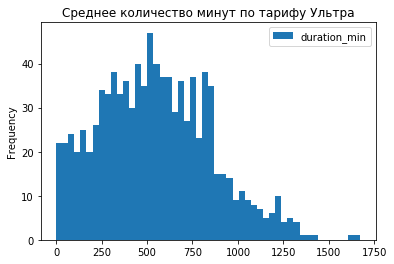

In [26]:
all_ultra['duration_min'].plot(
    kind = 'hist',
    bins=50,
    legend = True,
    title = 'Среднее количество минут по тарифу Ультра'
)

In [27]:
# Для сообщений по тарифу ультра
ultra_messages_mean = all_ultra['messages'].mean()
ultra_messages_var = np.var(all_ultra['messages'], ddof=1)
ultra_messages_std = np.std(all_ultra['messages'], ddof=1)
ultra_messages_mean, ultra_messages_var, ultra_messages_std

(61.161006289308176, 2109.6591828651995, 45.93102636416042)

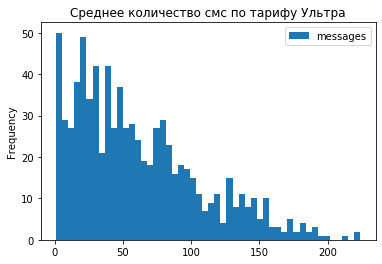

In [28]:
all_ultra['messages'].plot(
    kind = 'hist',
    bins=50,
    legend = True,
    title = 'Среднее количество смс по тарифу Ультра'
)

In [29]:
# Для интернета по тарифу ультра
ultra_gb_used_mean = all_ultra['gb_used'].mean()
ultra_gb_used_var = np.var(all_ultra['gb_used'], ddof=1)
ultra_gb_used_std = np.std(all_ultra['gb_used'], ddof=1)
ultra_gb_used_mean, ultra_gb_used_var, ultra_gb_used_std

(19.694358974358973, 94.14673405991682, 9.70292399536948)

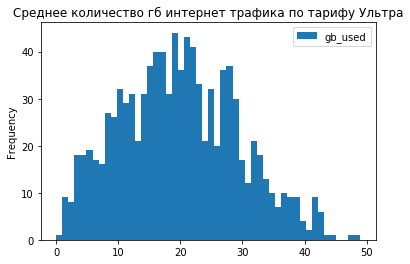

In [30]:
all_ultra['gb_used'].plot(
    kind = 'hist',
    bins=50,
    legend = True,
    title = 'Среднее количество гб интернет трафика по тарифу Ультра'
)

### Вывод Ультра
Пользователи тарифа Ультра в стреднем в месяц тратят 545 минут разговора, отправляют 61 смс и расходуют около 20 гб интернет трафика. Распределиня данных величин являются нормальными, разброс относительно не большой.

In [31]:
all_smart = all_group[all_group['tariff'] == 'smart']

In [32]:
# Для минут по тарифу смарт
smart_min_mean = all_smart['duration_min'].mean()
smart_min_var = np.var(all_smart['duration_min'], ddof=1)
smart_min_std = np.std(all_smart['duration_min'], ddof=1)
smart_min_mean, smart_min_var, smart_min_std

(419.0629779577148, 35844.1895513438, 189.3256177894154)

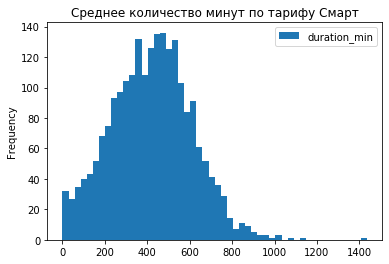

In [33]:
all_smart['duration_min'].plot(
    kind = 'hist',
    bins=50,
    legend = True,
    title = 'Среднее количество минут по тарифу Смарт'
)

In [34]:
# Для сообщений по тарифу смарт
smart_messages_mean = all_smart['messages'].mean()
smart_messages_var = np.var(all_smart['messages'], ddof=1)
smart_messages_std = np.std(all_smart['messages'], ddof=1)
smart_messages_mean, smart_messages_var, smart_messages_std

(38.71644120707596, 717.5942011753547, 26.787948804926344)

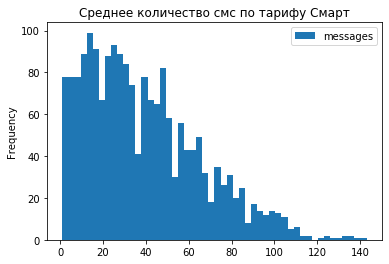

In [35]:
all_smart['messages'].plot(
    kind = 'hist',
    bins=50,
    legend = True,
    title = 'Среднее количество смс по тарифу Смарт'
)

In [36]:
# Для интернета по тарифу смарт
smart_gb_used_mean = all_smart['gb_used'].mean()
smart_gb_used_var = np.var(all_smart['gb_used'], ddof=1)
smart_gb_used_std = np.std(all_smart['gb_used'], ddof=1)
smart_gb_used_mean, smart_gb_used_var, smart_gb_used_std

(16.33617594254937, 32.92375582354312, 5.737922605224221)

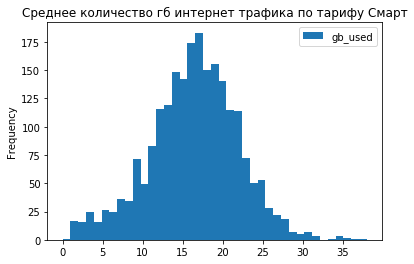

In [37]:
all_smart['gb_used'].plot(
    kind = 'hist',
    bins=39,
    legend = True,
    title = 'Среднее количество гб интернет трафика по тарифу Смарт'
)

### Вывод Смарт
Пользователи тарифа Сматрт в стреднем в месяц тратят 419 минут разговора, отправляют 39 смс и расходуют около 16 гб интернет трафика. Распределиня данных величин также являются нормальными, разброс относительно не большой.

In [38]:
# Сравнение средних выручек по тарифам:
all_group[all_group['tariff'] == 'ultra']['cash'].mean(), all_group[all_group['tariff'] == 'smart']['cash'].mean()

(2070.030425963489, 1289.6417040358745)

### Вывод
В среднем пользователи тарифа Ультра расходуют на 126 минут разговора больше (около 30%), на 22 смс больше (около 56%) и на 4 гб интернет трафика больше (около 25%). 

Тариф Ультра приносит в среднем ежемесячно с каждого пользователя на 782 руб. больше (на 60%). Это говорит о том, что при меньших расходах на связь приносит больше денег в компанию, идеальная бизнес модель!

## 5. Проверка гипотез
- средняя выручка пользователей тарифов «Ультра» и «Смарт» различаются;
- средняя выручка пользователей из Москвы отличается от выручки пользователей из других регионов.

#### Нулевая гипотеза H0: 
"Средняя выручка пользователей тарифов "Ультра" и "Смарт" равны".
#### Альтернативная гипотеза Н1: 
"Средняя выручка пользователей тарифов "Ультра" и "Смарт" не равны"

In [39]:
st.ttest_ind(all_ultra['cash'], all_smart['cash'], equal_var=False)

Ttest_indResult(statistic=37.047170235598124, pvalue=1.927011394420941e-250)

Полученное значение p-value говорит о том, что средний чек пользователей этих тарифов можеть совпадать, где-то в другой галактике, поэтому отвергаем Нулевую гипотезу, даже если alpha = 0.01.

#### Нулевая гипотеза H0: 
"Средние выручки пользователей из Москвы и выручки пользователей из других регионов равны".
#### Альтернативная гипотеза Н1: 
"Средние выручки пользователей из Москвы и выручки пользователей из других регионов не равны"

In [40]:
all_group = all_group.merge(users[['user_id', 'city']], how = 'right', on = 'user_id')

In [41]:
st.ttest_ind(
    all_group[all_group['city'] == 'Москва']['cash'],
    all_group[all_group['city'] != 'Москва']['cash']
)

Ttest_indResult(statistic=0.612764892018948, pvalue=0.5400751614511182)

Полученное значение p-value говорит о том, что средний чек пользователей Москвы и остальных городов можеть совпадать, с вероятностью более 50%, поэтому принимаем Нулевую гипотезу, даже если alpha = 0.05.

### Вывод 
Проверив данные гипотезы можно с огромной долей вероятности сказать, что средние выручки данных тарифов сильно отличаются. Но с большой долей вероятности можно говорить о том, что средние выручки с пользователей из Москвы не отличаются от средних выручек пользователей из других городов.

## 6. Общий вывод

В ходе проведения анализа были сопоставлены тарифы Смарт и Ультра компании Мегалайн. В выборке было 500 случайных клиентов компании с данными за 2018 год. В результате анализа выявлено следующее:
- Помесячные траты каждого пользователя
- В среднем пользователь тарифа Ультра расходует в месяц: 545 мин, 61 смс и 20 гб интренета
- В среднем пользователь тарифа Смарт расходует в месяц: 419 мин, 39 смс и 16 гб интренета
- Средняя ежемесечная выручка с пользователя тарифа Ультра на 782 руб. (на 60%) больше выручки пользователя тарифа Смарт
- Также отверглась гипотеза о равенстве средних выручек пользователей тарифов Смарт и Ультра
- С большой долей вероятности можно говорить о том, что средние выручки с пользователей из Москвы не отличаются от средних выручек пользователей из других городов


- И самое главное, для компании более прибыльным является тариф Ультра. Если бы были даны себестоимость минуты, смс и мб интернет трафика, можно было бы сказать, на сколько это выгоднее в цифрах.